Loaded image without alpha channel. Assuming all pixels are foreground.
Image dimensions: 563x579
Minimum size for merging components: 17 pixels (0.5% of foreground area)
Found 8 unique foreground colors: [(np.uint8(15), np.uint8(39), np.uint8(127)), (np.uint8(17), np.uint8(20), np.uint8(23)), (np.uint8(32), np.uint8(149), np.uint8(221)), (np.uint8(33), np.uint8(213), np.uint8(254)), (np.uint8(54), np.uint8(64), np.uint8(247)), (np.uint8(199), np.uint8(199), np.uint8(199)), (np.uint8(254), np.uint8(254), np.uint8(254)), (np.uint8(255), np.uint8(255), np.uint8(255))]

Step 1: Extracting, simplifying, and drawing contours...
  - Processed color (np.uint8(15), np.uint8(39), np.uint8(127)): Found 455 contours, drew 4 simplified shapes.
  - Processed color (np.uint8(17), np.uint8(20), np.uint8(23)): Found 16 contours, drew 15 simplified shapes.
  - Processed color (np.uint8(32), np.uint8(149), np.uint8(221)): Found 594 contours, drew 21 simplified shapes.
  - Processed color (np.uint8(33), 

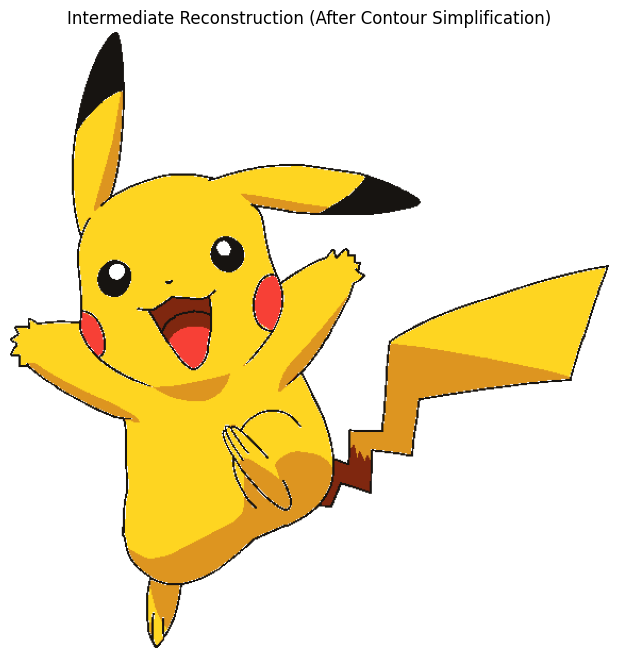


Step 2: Labeling components on simplified image and merging small ones...
Labeling components for 6 colors found in intermediate image...
Total initial components found after simplification: 41
Calculating region properties...

Processing regions with area less than merge threshold (17)...
Merging complete. Merged 14 small regions. Kept 0 small regions (no large neighbors).

Reconstructing final image after merging...

Calculating final element counts per color...

--- Final Element Counts After Merging ---
Color (15, 39, 127): 3 elements
Color (17, 20, 23): 6 elements
Color (254, 254, 254): 2 elements
Color (32, 149, 221): 8 elements
Color (33, 213, 254): 5 elements
Color (54, 64, 247): 3 elements
------------------------------------------
Total final elements: 27
------------------------------------------
Step 2 Complete. Displaying final reconstructed image...


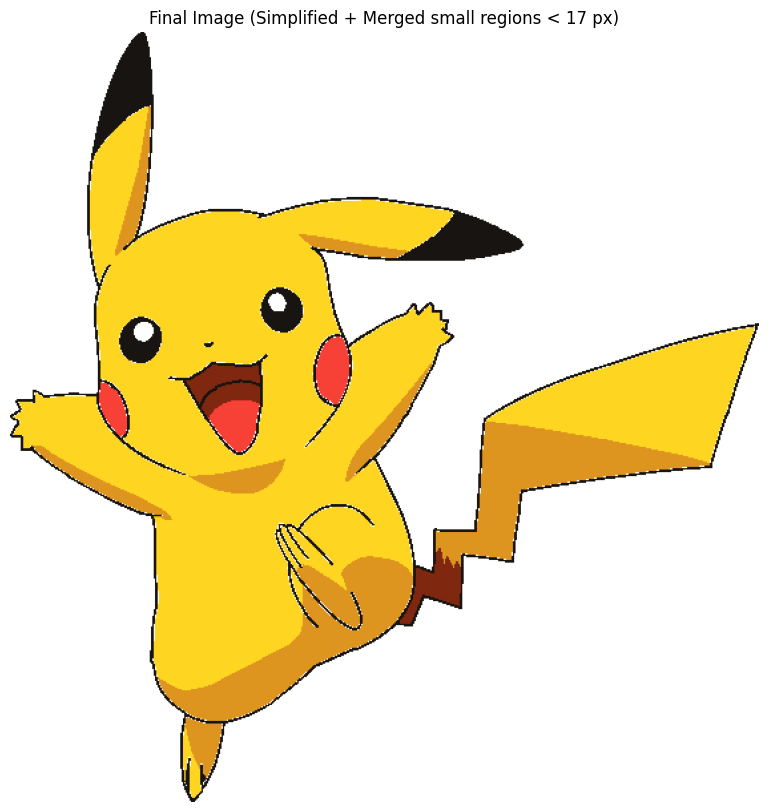

Saved final reconstructed image to reconstructed_simplified_merged_output.png


In [94]:
import cv2
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure # For connected components and region properties
from collections import Counter

# --- Parameters ----------------------------------------------------------------
IMAGE_PATH = "Pikachu_quant.png" # Make sure this image exists
MIN_SIZE_PERCENT = 0.5     # adjust as needed (e.g., 1% of image area)
BORDER_STRIP_SIZE = 1   # kernel size for eroding boundary pixels before contour finding
CONTOUR_SIMPLIFICATION_EPSILON = 0.0001 # Epsilon parameter for cv2.approxPolyDP (adjust sensitivity)
# Define connectivity for neighbor finding (1: 4-way, 2: 8-way)
CONNECTIVITY = 2 # Use 8-way connectivity for neighbors

# --- Load image (with alpha) and extract BGR + foreground mask ---------------
img = cv2.imread(IMAGE_PATH, cv2.IMREAD_UNCHANGED)
if img is None:
    # Attempt relative path if absolute fails or not provided
    try:
        script_dir = os.path.dirname(os.path.abspath(__file__))
        img_path_rel = os.path.join(script_dir, IMAGE_PATH)
        img = cv2.imread(img_path_rel, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise FileNotFoundError()
        else:
            IMAGE_PATH = img_path_rel # Update path if relative one worked
            print(f"Loaded image from relative path: {IMAGE_PATH}")
    except (FileNotFoundError, NameError): # NameError if __file__ not defined (e.g. interactive)
         print(f"Warning: Could not load '{IMAGE_PATH}' or find relative path. Check filename/path.")
         # Add error handling or exit if needed
         # For now, trying to continue assuming img might be loaded otherwise (e.g. notebook)
         if img is None:
              raise FileNotFoundError(f"Could not load '{IMAGE_PATH}'. Please ensure the file exists.")


# Separate channels
if img.shape[2] == 4:
    bgr = img[:, :, :3]
    alpha = img[:, :, 3]
    mask_fg = (alpha == 255) # Consider only fully opaque pixels as foreground
    print(f"Loaded image with alpha channel. Using alpha for foreground mask.")
else:
    bgr = img
    h, w = bgr.shape[:2]
    # Define a background color if needed, otherwise assume all is foreground
    # background_color = [255, 255, 255] # Example: White background
    # mask_fg = ~np.all(bgr == background_color, axis=2)
    mask_fg = np.ones(bgr.shape[:2], dtype=bool) # Assume all pixels are foreground
    print(f"Loaded image without alpha channel. Assuming all pixels are foreground.")

h, w = bgr.shape[:2]
print(f"Image dimensions: {w}x{h}")

# --- Compute minimum component size ------------------------------------------
num_fg_pixels = np.sum(mask_fg)
if num_fg_pixels == 0:
     raise ValueError("No foreground pixels found in the image based on the mask.")

MIN_SIZE = math.ceil((MIN_SIZE_PERCENT / 10000.0) * num_fg_pixels)
print(f"Minimum size for merging components: {MIN_SIZE} pixels ({MIN_SIZE_PERCENT}% of foreground area)")

# --- Build palette only from foreground pixels -------------------------------
fg_colors = bgr[mask_fg]
if fg_colors.size == 0:
    raise ValueError("Foreground mask resulted in zero pixels. Cannot build palette.")

palette = sorted(list(set(tuple(c) for c in fg_colors)))
print(f"Found {len(palette)} unique foreground colors: {palette}")

# --- Prepare border‐stripping kernel ------------------------------------------
border_kernel = cv2.getStructuringElement(
    cv2.MORPH_CROSS,
    (BORDER_STRIP_SIZE, BORDER_STRIP_SIZE)
)

# --- Create Intermediate Image with Simplified Contours ----------------------
# Start with a blank background (e.g., white)
intermediate_recon = np.full_like(bgr, (255, 255, 255), dtype=bgr.dtype)
print("\nStep 1: Extracting, simplifying, and drawing contours...")

# make a uint8 mask for bitwise ops
mask_fg_u8 = (mask_fg.astype(np.uint8) * 255)

for color in palette:
    # 1) Binary mask for exactly this color, then restrict to foreground
    mask_color = cv2.inRange(bgr, np.array(color), np.array(color))
    mask_color = cv2.bitwise_and(mask_color, mask_fg_u8)

    # Skip if no pixels of this color exist in foreground
    if cv2.countNonZero(mask_color) == 0:
        continue

    # 2) Erode to strip boundary pixels touching non-color (helps with cleaner contours)
    # Use BORDER_REPLICATE to avoid shrinking from image edges
    mask_clean = cv2.erode(mask_color, border_kernel, iterations=1, borderType=cv2.BORDER_REPLICATE)

    # 3) Find contours in the cleaned mask
    # Use RETR_EXTERNAL if you only want outer boundaries, RETR_TREE for hierarchy
    contours, _ = cv2.findContours(mask_clean.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # 4) Create a blank canvas for this color's simplified shapes
    canvas_filled_simplified = np.zeros_like(mask_clean) # uint8 mask

    # 5) Simplify contours and fill them on the canvas
    simplified_contours_for_color = []
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        # Avoid division by zero for very small contours
        if perimeter > 0:
            epsilon = CONTOUR_SIMPLIFICATION_EPSILON * perimeter
            simplified_contour = cv2.approxPolyDP(contour, epsilon, True)
            # Check if simplified contour is not empty
            if simplified_contour.shape[0] >= 3:
                 simplified_contours_for_color.append(simplified_contour)
        # else: keep original if perimeter is 0? Or discard? Discarding for now.

    # Fill the simplified contours on the canvas for this color
    if simplified_contours_for_color:
        cv2.drawContours(canvas_filled_simplified, simplified_contours_for_color, -1, 255, thickness=cv2.FILLED)

    # 6) Draw the result onto the intermediate reconstruction image
    mask_bool = canvas_filled_simplified.astype(bool)
    intermediate_recon[mask_bool] = color # Assign the actual color

    print(f"  - Processed color {color}: Found {len(contours)} contours, drew {len(simplified_contours_for_color)} simplified shapes.")


print("\nStep 1 Complete. Intermediate image with simplified shapes generated.")

# --- Optional: Visualize the Intermediate Image ---
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(intermediate_recon, cv2.COLOR_BGR2RGB))
plt.title("Intermediate Reconstruction (After Contour Simplification)")
plt.axis('off')
plt.show()


# --- Step 2: Label Components on Intermediate Image and Merge Small Ones ---
print("\nStep 2: Labeling components on simplified image and merging small ones...")

# Use the intermediate image as the basis for labeling
bgr_for_labeling = intermediate_recon # Renaming for clarity
# Define background color used in intermediate_recon (important for labeling)
background_color_bgr = (255, 255, 255)

# Create an overall label image. Label 0 is background.
labeled_image = np.zeros((h, w), dtype=np.int32)
label_to_color = {} # Dictionary to map final labels back to their BGR color
current_label = 1 # Start labeling from 1

# Find unique colors present in the intermediate image (excluding background)
unique_colors_in_intermediate = np.unique(bgr_for_labeling.reshape(-1, 3), axis=0)
palette_from_intermediate = [tuple(c) for c in unique_colors_in_intermediate if tuple(c) != background_color_bgr]

print(f"Labeling components for {len(palette_from_intermediate)} colors found in intermediate image...")
for color in palette_from_intermediate:
    # 1) Binary mask for exactly this color in the intermediate image
    # Important: Compare with the numpy array version of the color
    mask_color = np.all(bgr_for_labeling == np.array(color), axis=2)

    if not np.any(mask_color): # Should not happen based on palette creation, but safe check
        continue

    # 2) Label connected components within this color mask
    labeled_color_mask = measure.label(mask_color, connectivity=CONNECTIVITY, background=0)

    # 3) Add these components to the main labeled_image with unique labels
    num_labels_in_color = np.max(labeled_color_mask)
    for i in range(1, num_labels_in_color + 1):
        component_mask = (labeled_color_mask == i)
        labeled_image[component_mask] = current_label
        label_to_color[current_label] = tuple(map(int, color)) # Store color
        current_label += 1

print(f"Total initial components found after simplification: {current_label - 1}")

# --- Analyze region properties ---------------------------------------------
if current_label == 1:
    print("No components found after simplification. Skipping merging.")
    # Final image will be the intermediate image or just background
    final_recon = intermediate_recon.copy()
else:
    print("Calculating region properties...")
    # Ensure labeled_image has positive integers for regionprops
    regions = measure.regionprops(labeled_image, cache=True) # Use cache=True for potential speedup with coord access

    # Create a map from label ID to region object for quick access
    region_map = {region.label: region for region in regions}

    # --- Identify and process small components ---------------------------------
    area_threshold = MIN_SIZE # Use the MIN_SIZE calculated earlier
    print(f"\nProcessing regions with area less than merge threshold ({area_threshold})...")

    # We need to modify the labeled_image in place, so iterate carefully
    labels_to_process = list(region_map.keys())
    modified_labels = {} # Keep track of changes: {old_label: new_label}

    merge_count = 0
    no_neighbor_count = 0

    for label_id in labels_to_process:
        # Skip if this label was already merged into another
        if label_id in modified_labels:
            continue
        # Skip if label somehow doesn't exist in map (shouldn't happen)
        if label_id not in region_map:
            continue

        region = region_map[label_id]

        if region.area < area_threshold:
            # This region is small. Find its neighbors.
            neighbor_labels_count = Counter()

            # Iterate through the coordinates - can be slow for large regions,
            # but regionprops caches coords. Alternative: find boundaries first.
            for r, c in region.coords:
                # Check 8 neighbors (or 4 if connectivity=1)
                for dr in range(-1, 2):
                    for dc in range(-1, 2):
                        if dr == 0 and dc == 0: continue
                        if CONNECTIVITY == 1 and abs(dr) + abs(dc) != 1: continue

                        nr, nc = r + dr, c + dc
                        if 0 <= nr < h and 0 <= nc < w:
                            neighbor_label = labeled_image[nr, nc]
                            # Get the *current* label of the neighbor, in case it was already merged
                            actual_neighbor_label = modified_labels.get(neighbor_label, neighbor_label)

                            # Count neighbor if it's not background (0) and not part of the *original* small region
                            # or any region that has already been merged *into* this small region (less likely scenario)
                            if actual_neighbor_label != 0 and actual_neighbor_label != label_id:
                                neighbor_labels_count[actual_neighbor_label] += 1

            # Find the best neighbor to merge with
            best_neighbor_label = None
            potential_neighbors = sorted(
                neighbor_labels_count.items(),
                key=lambda item: item[1], # Sort by count (shared border pixels)
                reverse=True
            )

            for potential_neighbor_label, count in potential_neighbors:
                # We already resolved merged labels when counting, so potential_neighbor_label is the 'current' label
                if potential_neighbor_label in region_map:
                     neighbor_region = region_map[potential_neighbor_label]
                     # Check if the neighbor is LARGE ENOUGH (relative to MIN_SIZE)
                     if neighbor_region.area >= area_threshold:
                        best_neighbor_label = potential_neighbor_label
                        # print(f"  - Small region {label_id} (Area: {region.area}, Color: {label_to_color[label_id]}): Merging into large neighbor {best_neighbor_label} (Area: {neighbor_region.area}, Color: {label_to_color[best_neighbor_label]}) based on {count} shared border points.")
                        break # Found the best large neighbor

            # If a suitable neighbor was found, update the label map and tracking
            if best_neighbor_label is not None:
                # Update the labeled_image for all pixels of the small region
                labeled_image[region.coords[:, 0], region.coords[:, 1]] = best_neighbor_label
                # Record the merge action: small label now points to the neighbor label
                modified_labels[label_id] = best_neighbor_label
                merge_count += 1
                # Remove the merged region from the map (optional, careful if iterating keys)
                # del region_map[label_id]
            else:
                # print(f"  - Small region {label_id} (Area: {region.area}, Color: {label_to_color[label_id]}): No suitable large neighbor found. Kept original color.")
                no_neighbor_count += 1

    print(f"Merging complete. Merged {merge_count} small regions. Kept {no_neighbor_count} small regions (no large neighbors).")

    # --- Reconstruct the final image from the modified labeled_image --------
    print("\nReconstructing final image after merging...")
    # Start with the background color used before
    final_recon = np.full_like(bgr, background_color_bgr, dtype=bgr.dtype)

    # Get final unique labels present in the image after merging
    final_labels_present = np.unique(labeled_image)

    # Apply colors based on the final labels
    for label_id in final_labels_present:
        if label_id == 0: # Skip background
            continue

        # Find the original label this corresponds to (trace back merges)
        current_id = label_id
        visited = {current_id} # Detect cycles, though unlikely here
        while current_id in modified_labels:
            current_id = modified_labels[current_id]
            if current_id in visited:
                 print(f"Warning: Detected label cycle involving {current_id}. Breaking.")
                 break # Avoid infinite loop in case of unexpected cycle
            visited.add(current_id)

        # Assign the color of the final parent label
        if current_id in label_to_color:
            final_color = label_to_color[current_id]
            mask = (labeled_image == label_id)
            final_recon[mask] = final_color
        else:
            # This case means a label exists in labeled_image whose original
            # color wasn't mapped, or it traced back to a deleted/invalid label.
             print(f"Warning: Could not find final color mapping for label {label_id} (traced to {current_id}). Pixels might remain background.")



# --- Calculate and Display Final Element Counts ---
print("\nCalculating final element counts per color...")
final_color_counts = Counter()
total_final_elements = 0

# Get unique labels present in the *final* labeled image (excluding background 0)
final_labels_in_image = np.unique(labeled_image)
final_labels_in_image = final_labels_in_image[final_labels_in_image != 0] # Exclude 0

for label_id in final_labels_in_image:
    # Find the original root label to determine the color, tracing back merges
    current_id = label_id
    visited = {current_id}
    while current_id in modified_labels:
        parent_id = modified_labels[current_id]
        if parent_id == current_id: # Self-reference, should not happen but prevents infinite loop
            print(f"Warning: Label {current_id} merged into itself. Breaking trace.")
            break
        if parent_id in visited:
            print(f"Warning: Detected label cycle involving {parent_id} when tracing {label_id}. Breaking.")
            # Assign color based on the loop entry point or skip
            current_id = -1 # Mark as invalid/untraceable
            break
        visited.add(parent_id)
        current_id = parent_id


    # Get the color associated with the root label
    if current_id != -1 and current_id in label_to_color:
        final_color = label_to_color[current_id]
        final_color_counts[final_color] += 1
    # else: This label's root color couldn't be determined (already warned during recon)


print("\n--- Final Element Counts After Merging ---")
# Sort by color string for consistent output order
sorted_colors = sorted(final_color_counts.keys(), key=lambda c: str(c))
for color in sorted_colors:
    count = final_color_counts[color]
    print(f"Color {color}: {count} elements")
    total_final_elements += count

print(f"------------------------------------------")
print(f"Total final elements: {total_final_elements}")
print(f"------------------------------------------")

# --- Final Visualisation and Saving ---------------------------------------
print("Step 2 Complete. Displaying final reconstructed image...")
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(final_recon, cv2.COLOR_BGR2RGB))
plt.title(f"Final Image (Simplified + Merged small regions < {MIN_SIZE} px)")
plt.axis('off')
plt.show()

# --- Save the result (optional) ---------------------------------------------
output_filename = "reconstructed_simplified_merged_output.png"
# Add alpha handling if needed (similar to previous example)
# ...
cv2.imwrite(output_filename, final_recon)
print(f"Saved final reconstructed image to {output_filename}")


--- Visualizing Final Elements Grouped by Color ---
Mapping final labels to their effective colors...
Found 6 distinct colors with elements remaining after merging.


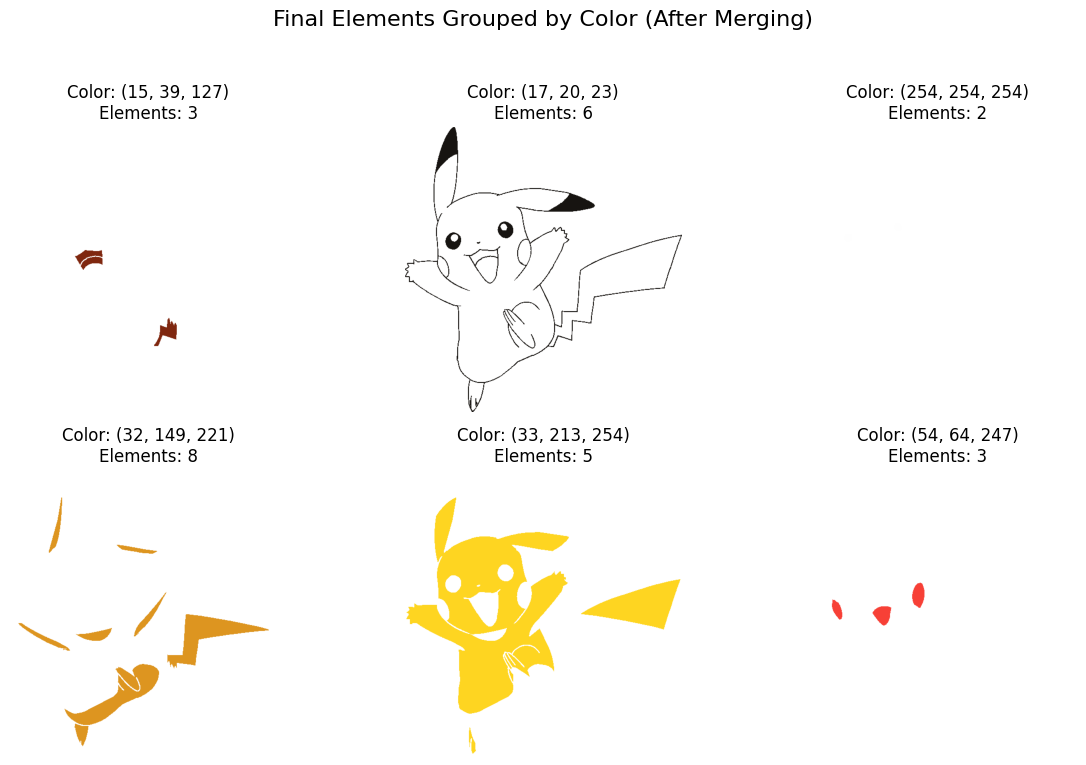

In [99]:
from collections import defaultdict
print("\n--- Visualizing Final Elements Grouped by Color ---")

# Check if the labeling/merging step produced results
if 'labeled_image' not in locals() or np.max(labeled_image) == 0:
    print("No labeled components found to visualize.")
else:
    # --- Step 1: Determine final colors and the labels associated with them ---
    labels_per_final_color = defaultdict(list)
    unique_final_labels = np.unique(labeled_image)
    unique_final_labels = unique_final_labels[unique_final_labels != 0] # Exclude background

    print("Mapping final labels to their effective colors...")
    for label_id in unique_final_labels:
        # Trace back to the root label to find the definitive color
        current_id = label_id
        visited = {current_id}
        while current_id in modified_labels:
            parent_id = modified_labels[current_id]
            if parent_id == current_id or parent_id in visited: # Cycle detection
                 current_id = -1 # Mark as invalid/untraceable
                 break
            visited.add(parent_id)
            current_id = parent_id

        # Get the color of the root label
        if current_id != -1 and current_id in label_to_color:
            final_color = label_to_color[current_id]
            labels_per_final_color[final_color].append(label_id)
        # else: Color couldn't be determined for this label

    final_colors_present = sorted(list(labels_per_final_color.keys()), key=str)
    num_colors = len(final_colors_present)

    if num_colors == 0:
        print("No final colored elements found to display.")
    else:
        print(f"Found {num_colors} distinct colors with elements remaining after merging.")

        # --- Step 2: Setup Matplotlib Subplots ---
        # Determine grid size (e.g., aim for roughly square)
        cols = math.ceil(math.sqrt(num_colors))
        rows = math.ceil(num_colors / cols)
        fig_width = cols * 4 # Adjust figure size as needed
        fig_height = rows * 4
        fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height), squeeze=False)
        # Flatten axes array for easy iteration
        axes = axes.ravel()

        # --- Step 3: Plot elements for each color ---
        for i, color in enumerate(final_colors_present):
            ax = axes[i]
            # Create a blank canvas with the background color
            canvas = np.full((h, w, 3), background_color_bgr, dtype=np.uint8)

            # Get the list of final labels corresponding to this color
            labels_to_draw = labels_per_final_color[color]

            if labels_to_draw:
                # Create a mask where the labeled_image contains any of these labels
                mask_for_color = np.isin(labeled_image, labels_to_draw)
                # Apply the color to the canvas using the mask
                canvas[mask_for_color] = color

            # Display the canvas on the subplot
            # Convert BGR canvas to RGB for matplotlib display
            ax.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
            ax.set_title(f"Color: {color}\nElements: {len(labels_to_draw)}") # Or use final_color_counts[color]
            ax.axis('off')

        # Hide any unused subplots
        for j in range(num_colors, len(axes)):
            axes[j].axis('off')

        plt.suptitle("Final Elements Grouped by Color (After Merging)", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()


## old

ID → parent, depth, area, perimeter:
  3 →   -, d=0, a=107390, p=2936
 17 →   3, d=1, a=64434, p=2796
 18 →   3, d=1, a=9847, p=526
 15 →   3, d=1, a=7212, p=789
 12 →   3, d=1, a=6785, p=614
  2 →   3, d=1, a=966, p=218
 22 →   3, d=1, a=905, p=127
 11 →   3, d=1, a=788, p=235
 13 →   3, d=1, a=782, p=270
  9 →   3, d=1, a=738, p=245
 16 →   3, d=1, a=688, p=133
 10 →   3, d=1, a=512, p=176
 23 →   3, d=1, a=486, p=101
 21 →   3, d=1, a=269, p=153
 20 →   3, d=1, a=75, p=57
 19 →   3, d=1, a=51, p=66
  7 →  17, d=2, a=2768, p=257
 14 →  17, d=2, a=873, p=170
  5 →  17, d=2, a=814, p=107
  4 →  17, d=2, a=784, p=105
  8 →  17, d=2, a=328, p=769
  6 →  17, d=2, a=11, p=16
 24 →   7, d=3, a=958, p=125
  0 →   7, d=3, a=649, p=151
  1 →   7, d=3, a=521, p=123
 26 →   5, d=3, a=126, p=43
 25 →   4, d=3, a=110, p=40


C:\Users\adamk\AppData\Local\Temp\ipykernel_19060\2355549074.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


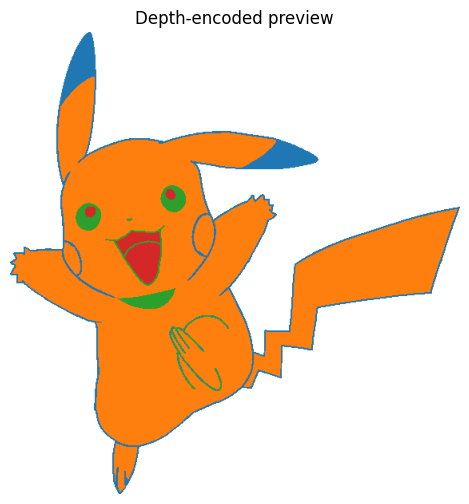

In [66]:
# --- CELL 3: Convert component masks into element dicts with contours ----------------
import numpy as np
import cv2

elements = []  # List of dicts: id, colour, contour, area, perimeter, centroid, parent, children, depth

# labels_per_final_color was built in CELL 2: { colour: [label_id, …], … }
for colour, label_ids in labels_per_final_color.items():
    for label_id in label_ids:
        # build a binary mask for this component
        comp_mask = (labeled_image == label_id).astype(np.uint8) * 255

        # find its outer contour
        cnts, _ = cv2.findContours(comp_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        if not cnts:
            continue
        cnt = cnts[0]

        # compute properties
        area = cv2.contourArea(cnt)
        peri = cv2.arcLength(cnt, True)
        M    = cv2.moments(cnt)
        centroid = np.array([
            M['m10'] / max(M['m00'], 1e-6),
            M['m01'] / max(M['m00'], 1e-6)
        ])

        eid = len(elements)
        elements.append({
            'id':       eid,
            'colour':   colour,
            'contour':  cnt,
            'area':     area,
            'perimeter':peri,
            'centroid': centroid,
            'parent':   None,
            'children': [],
            'depth':    None,
        })

if not elements:
    raise RuntimeError("No elements extracted; check palette or MIN_SIZE.")

# --- Precompute bounding boxes for fast containment tests --------------------
for e in elements:
    e['bbox'] = cv2.boundingRect(e['contour'])  # (x,y,w,h)

# --- Determine parent-child relationships by containment ---------------------
for inner in elements:
    xi, yi, wi, hi = inner['bbox']
    best_parent, best_diff = None, float('inf')
    for outer in elements:
        if outer['area'] <= inner['area']:
            continue
        xo, yo, wo, ho = outer['bbox']
        # bounding box containment
        if xo > xi or yo > yi or xo+wo < xi+wi or yo+ho < yi+hi:
            continue
        # centroid inside outer contour?
        if cv2.pointPolygonTest(outer['contour'],
                                tuple(inner['centroid']), False) < 0:
            continue
        diff = outer['area'] - inner['area']
        if diff < best_diff:
            best_diff, best_parent = diff, outer
    if best_parent is not None:
        inner['parent'] = best_parent['id']
        best_parent['children'].append(inner['id'])

# --- Recursively assign depth (root depth=0) ---------------------------------
def set_depth(e, d):
    e['depth'] = d
    for cid in e['children']:
        set_depth(elements[cid], d+1)

for e in elements:
    if e['parent'] is None:
        set_depth(e, 0)

# --- Summary of layering -----------------------------------------------------
layered = sorted(elements, key=lambda e: (e['depth'], -e['area']))
print("ID → parent, depth, area, perimeter:")
for e in layered:
    print(f"{e['id']:>3} → {e['parent'] or '-':>3}, d={e['depth']}, "
          f"a={e['area']:.0f}, p={e['perimeter']:.0f}")

# --- Visual check: color‑coded by depth --------------------------------------
cmap = plt.cm.get_cmap('tab10')
depth_canvas = np.full((h, w, 3), 255, np.uint8)
for e in layered:
    col_idx = e['depth'] % 10
    # matplotlib colormap gives RGB in [0,1], convert and reverse for BGR
    fake = tuple(int(c*255) for c in cmap(col_idx)[:3][::-1])
    cv2.drawContours(depth_canvas, [e['contour']], -1, fake, cv2.FILLED)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(depth_canvas, cv2.COLOR_BGR2RGB))
plt.title('Depth‑encoded preview')
plt.axis('off')
plt.show()


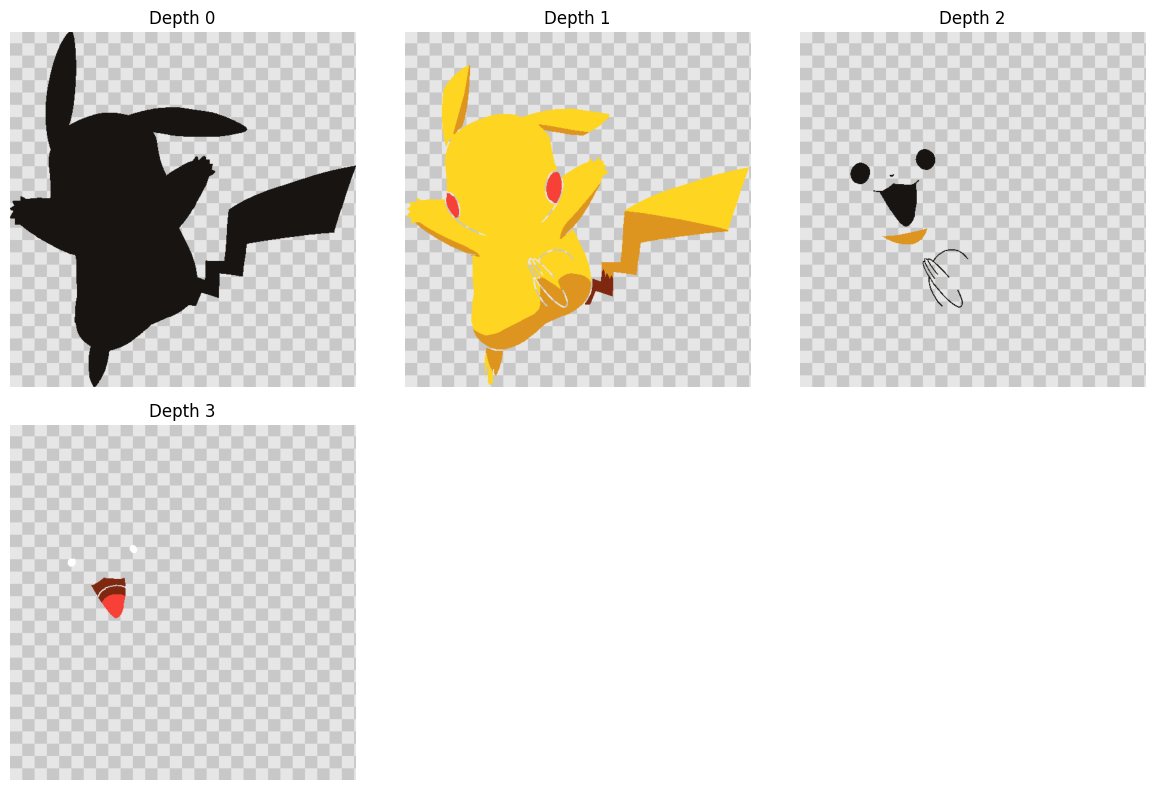

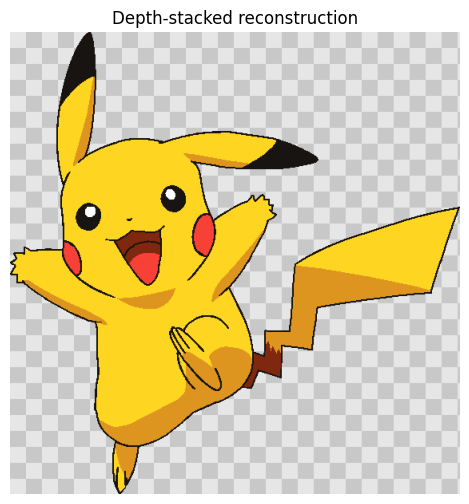

In [67]:
def make_checkerboard(H, W, block=20, a=(230,230,230), b=(200,200,200)):
    yy, xx = np.indices((H,W))
    patt = ((yy//block)+(xx//block))%2
    board = np.empty((H,W,3), np.uint8)
    board[patt==0] = a
    board[patt==1] = b
    return board

# Generate canvases per depth
depths = sorted({e['depth'] for e in elements})
canvases = []
for d in depths:
    cb = make_checkerboard(h, w)
    for e in elements:
        if e['depth']==d:
            cv2.drawContours(cb, [e['contour']], -1, e['colour'], cv2.FILLED)
    canvases.append((d, cb))

# Display in grid
cols, rows = 3, math.ceil(len(canvases)/3)
plt.figure(figsize=(cols*4, rows*4))
for i,(d,cb) in enumerate(canvases,1):
    plt.subplot(rows,cols,i)
    plt.imshow(cv2.cvtColor(cb, cv2.COLOR_BGR2RGB))
    plt.title(f'Depth {d}')
    plt.axis('off')
# fill empty slots
for j in range(i+1, rows*cols+1):
    plt.subplot(rows,cols,j); plt.axis('off')
plt.tight_layout(); plt.show()

# Final reconstruction
final = make_checkerboard(h, w)
for d in depths:
    for e in elements:
        if e['depth']==d:
            cv2.drawContours(final, [e['contour']], -1, e['colour'], cv2.FILLED)
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
plt.title('Depth‑stacked reconstruction')
plt.axis('off')
plt.show()

## new

comlexities:

if an element stradles between two different colored elements such as the pikachu leg it will not 

laser printer where we color elenments after will have duplicate elements since the cutter will also produce the extra internal cut ones

Extracting elements and their properties...
Extracted 27 elements initially.
Determining parent-child relationships...
Assigning depth based on hierarchy...
Found and processed 1 root elements.

--- Layering Summary (Valid Depth Elements) ---
ID → ParentID, Depth, LabelID, Area, Perimeter, Children IDs:
  3 →   -, d=0 , L=5  , a=107390, p=2936, children=[2, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23]
  2 →   3, d=1 , L=4  , a=966, p=218, children=[]
  9 →   3, d=1 , L=11 , a=738, p=245, children=[]
 10 →   3, d=1 , L=12 , a=512, p=176, children=[]
 11 →   3, d=1 , L=16 , a=788, p=235, children=[]
 12 →   3, d=1 , L=20 , a=6785, p=614, children=[]
 13 →   3, d=1 , L=21 , a=782, p=270, children=[]
 15 →   3, d=1 , L=26 , a=7212, p=789, children=[]
 16 →   3, d=1 , L=27 , a=688, p=133, children=[]
 17 →   3, d=1 , L=30 , a=64434, p=2796, children=[4, 5, 6, 7, 8, 14]
 18 →   3, d=1 , L=31 , a=9847, p=526, children=[]
 19 →   3, d=1 , L=33 , a=51, p=66, children=[]
 20 →   3, d=1

C:\Users\adamk\AppData\Local\Temp\ipykernel_19060\1203166315.py:139: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


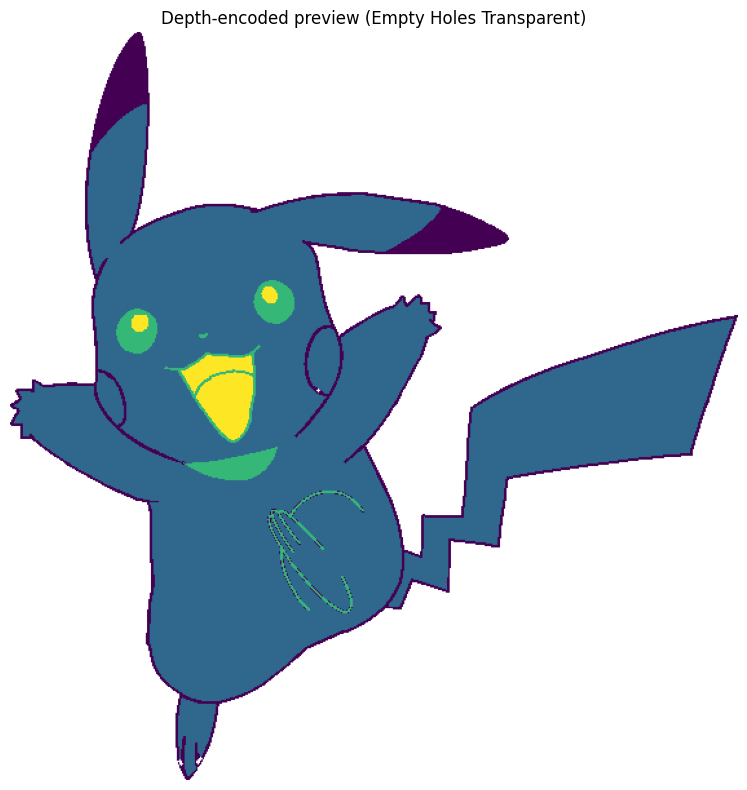


Visualization complete.


In [100]:
# --- Convert component masks into element dicts with contours ----------------

elements = []  # List of dicts: id, label_id, colour, contour, area, perimeter, centroid, parent, children, depth, bbox

element_id_counter = 0
label_to_element_id = {} # Map original label_id to our element id for reference

print("Extracting elements and their properties...")
for colour, label_ids in labels_per_final_color.items():
    for label_id in label_ids:
        # build a binary mask for this component
        comp_mask = (labeled_image == label_id).astype(np.uint8) * 255
        if cv2.countNonZero(comp_mask) == 0:
             # This might happen if merging logic created an empty label group
             # print(f"Warning: Label {label_id} (Color: {colour}) has no pixels in labeled_image. Skipping.")
             continue

        # find its *outer* contour only for calculating basic properties
        # Use RETR_EXTERNAL to ensure we get only the main boundary
        cnts_ext, _ = cv2.findContours(comp_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if not cnts_ext:
            # print(f"Warning: No external contour found for label {label_id}. Skipping.")
            continue
        # Assume the largest external contour is the main one if multiple found (can happen with noise)
        cnt = max(cnts_ext, key=cv2.contourArea)
        if cv2.contourArea(cnt) < 1: # Skip tiny contours that might be noise
             # print(f"Warning: External contour for label {label_id} has near-zero area ({cv2.contourArea(cnt)}). Skipping.")
             continue

        # compute properties using the main outer contour
        area = cv2.contourArea(cnt)
        peri = cv2.arcLength(cnt, True)
        M = cv2.moments(cnt)
        # Add small epsilon to prevent division by zero for very small/thin contours
        m00 = M['m00'] + 1e-6
        centroid = np.array([ M['m10'] / m00, M['m01'] / m00 ])

        # Assign a unique element ID
        eid = element_id_counter
        elements.append({
            'id':         eid,
            'label_id':   label_id, # <<< Store the original label_id
            'colour':     colour,
            'contour':    cnt,      # Store the main outer contour
            'area':       area,     # Area based on the outer contour
            'perimeter':  peri,
            'centroid':   centroid,
            'parent':     None,
            'children':   [],       # Initialized as empty list
            'depth':      None,
            'bbox':       cv2.boundingRect(cnt) # (x,y,w,h) based on outer contour
        })
        label_to_element_id[label_id] = eid
        element_id_counter += 1

if not elements:
    raise RuntimeError("No elements extracted; check labeled_image, labels_per_final_color, or MIN_SIZE in previous step.")

print(f"Extracted {len(elements)} elements initially.")

# --- Determine parent-child relationships by containment ---------------------
print("Determining parent-child relationships...")
# (This section remains unchanged from the previous version)
for i in range(len(elements)):
    inner = elements[i]
    xi, yi, wi, hi = inner['bbox']
    best_parent_id, best_diff = None, float('inf')

    for j in range(len(elements)):
        if i == j: continue # Don't compare element with itself
        outer = elements[j]

        if outer['area'] <= inner['area']: continue
        xo, yo, wo, ho = outer['bbox']
        if xo > xi or yo > yi or xo + wo < xi + wi or yo + ho < yi + hi: continue
        if cv2.pointPolygonTest(outer['contour'], tuple(inner['centroid']), False) < 0: continue

        diff = outer['area'] - inner['area']
        if diff < best_diff:
            best_diff = diff
            best_parent_id = outer['id']

    if best_parent_id is not None:
        inner['parent'] = best_parent_id
        elements[best_parent_id]['children'].append(inner['id'])


# --- Recursively assign depth (root depth=0) ---------------------------------
print("Assigning depth based on hierarchy...")
# (This section remains unchanged from the previous version)
def set_depth_recursive(element_id, current_depth, visited_recursion):
    if element_id in visited_recursion:
        print(f"Warning: Cycle detected involving element {element_id}. Cannot assign depth reliably.")
        elements[element_id]['depth'] = -1
        return

    if elements[element_id]['depth'] is not None and elements[element_id]['depth'] != -1:
        if elements[element_id]['depth'] != current_depth:
             print(f"Warning: Element {element_id} encountered again with different depth ({current_depth} vs {elements[element_id]['depth']}). Keeping first.")
        return

    elements[element_id]['depth'] = current_depth
    visited_recursion.add(element_id)
    for child_id in elements[element_id]['children']:
        set_depth_recursive(child_id, current_depth + 1, visited_recursion)
    visited_recursion.remove(element_id)

root_elements_count = 0
for i in range(len(elements)):
    if elements[i]['parent'] is None:
        if elements[i]['depth'] is None:
             set_depth_recursive(elements[i]['id'], 0, set())
             root_elements_count += 1

print(f"Found and processed {root_elements_count} root elements.")
unassigned_count = 0
for i in range(len(elements)):
    if elements[i]['depth'] is None or elements[i]['depth'] == -1:
        unassigned_count += 1
        # print(f"Warning: Element {elements[i]['id']} (Label: {elements[i]['label_id']}, Color: {elements[i]['colour']}) has invalid/unassigned depth ({elements[i]['depth']}).")
if unassigned_count > 0:
     print(f"Total elements with unassigned/invalid depth: {unassigned_count}")


# --- Summary of layering -----------------------------------------------------
# (This section remains unchanged from the previous version)
valid_elements = [e for e in elements if e['depth'] is not None and e['depth'] != -1]
layered = sorted(valid_elements, key=lambda e: (e['depth']))
print("\n--- Layering Summary (Valid Depth Elements) ---")
print("ID → ParentID, Depth, LabelID, Area, Perimeter, Children IDs:")
for e in layered:
    parent_str = str(e['parent']) if e['parent'] is not None else '-'
    print(f"{e['id']:>3} → {parent_str:>3}, d={e['depth']:<2}, L={e['label_id']:<3}, "
          f"a={e['area']:.0f}, p={e['perimeter']:.0f}, children={e['children']}")


# --- Visual check: color‑coded by depth using MASKING for hole handling ------
print("\nGenerating depth-encoded visualization using masking for hole handling...")
cmap = plt.cm.get_cmap('viridis')
depth_canvas = np.full((h, w, 3), 255, np.uint8) # White background (BGR)

# Sort elements for drawing: parents before children, larger areas first at same depth.
draw_order = sorted(elements, key=lambda e: (e['depth'] if e['depth'] is not None and e['depth'] != -1 else float('inf'), -e['area']))

for e in draw_order:
    if e['depth'] is None or e['depth'] == -1: continue # Skip invalid depth

    # --- Get Element Color based on Depth ---
    max_valid_depth = max((el['depth'] for el in valid_elements), default=0)
    norm_depth = min(e['depth'] / (max_valid_depth + 1e-6), 1.0) if max_valid_depth > 0 else 0.0
    fake_rgba = cmap(norm_depth)
    fake_bgr = tuple(int(c * 255) for c in fake_rgba[:3][::-1])

    # --- Create Mask for this Element (Outer Contour MINUS Empty Holes) ---

    # 1. Start with an empty mask
    element_mask = np.zeros((h, w), dtype=np.uint8)

    # 2. Find all contours and hierarchy for the original component mask
    comp_mask_holes = (labeled_image == e['label_id']).astype(np.uint8) * 255
    contours_including_holes, hierarchy_holes = cv2.findContours(
        comp_mask_holes, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
    )

    if hierarchy_holes is None or len(hierarchy_holes) == 0:
        # If no contours/hierarchy, maybe just draw the stored outer contour?
        # This might happen for elements without holes or issues in contour finding.
        # Fallback: Draw the main contour stored earlier, assuming no holes to worry about.
        cv2.drawContours(element_mask, [e['contour']], -1, 255, cv2.FILLED)
        # Apply color using this simplified mask
        depth_canvas[element_mask == 255] = fake_bgr
        continue # Skip the rest of the hole processing for this element


    hierarchy_holes = hierarchy_holes[0] # Remove outer list wrapper

    # 3. Identify the index of the main outer contour within contours_including_holes
    outer_contour_index_in_list = -1
    possible_outer_indices = [idx for idx, hier_info in enumerate(hierarchy_holes) if hier_info[3] == -1]
    if not possible_outer_indices:
         print(f"Warning: Could not find outer contour index (-1 parent) for element {e['id']} (label {e['label_id']}). Using stored contour as fallback.")
         # Fallback: Draw the stored main contour, assuming no complex holes
         cv2.drawContours(element_mask, [e['contour']], -1, 255, cv2.FILLED)
    elif len(possible_outer_indices) == 1:
        outer_contour_index_in_list = possible_outer_indices[0]
        # Draw the identified outer contour filled white (255) onto the mask
        cv2.drawContours(element_mask, [contours_including_holes[outer_contour_index_in_list]], -1, 255, cv2.FILLED)
    else:
        # Multiple top-level contours found, select the largest
        outer_contour_index_in_list = max(possible_outer_indices, key=lambda idx: cv2.contourArea(contours_including_holes[idx]))
        print(f"Warning: Multiple top-level contours found for element {e['id']} (label {e['label_id']}). Selecting largest as outer.")
        # Draw the identified outer contour filled white (255) onto the mask
        cv2.drawContours(element_mask, [contours_including_holes[outer_contour_index_in_list]], -1, 255, cv2.FILLED)

    # Only proceed with hole removal if we successfully identified an outer contour and drew it
    if outer_contour_index_in_list != -1:
        # 4. Find and process direct holes of the outer contour
        empty_hole_contours = []
        for hole_index, hier_info in enumerate(hierarchy_holes):
            # Check if this contour's parent is the main outer contour
            if hier_info[3] == outer_contour_index_in_list:
                hole_contour = contours_including_holes[hole_index]
                if cv2.contourArea(hole_contour) < 1: continue # Skip tiny holes

                # Check if this hole contains any children of element 'e'
                is_empty_hole = True
                # look for _any_ element at strictly greater depth
                deeper = [el for el in elements if el['depth'] is not None and el['depth'] > e['depth']]
                for other in deeper:
                    # using centroid test; you could also test mask overlap if you want
                    if cv2.pointPolygonTest(hole_contour, tuple(other['centroid']), False) >= 0:
                        is_empty_hole = False
                        break

                if is_empty_hole:
                    # Store this empty hole contour to be erased from the mask
                    empty_hole_contours.append(hole_contour)

        # 5. Erase the empty holes from the mask by drawing them filled with black (0)
        if empty_hole_contours:
            # print(f"Debug: Erasing {len(empty_hole_contours)} empty holes from mask for element {e['id']}.")
            cv2.drawContours(element_mask, empty_hole_contours, -1, 0, cv2.FILLED)


    # --- Apply Color using the Final Mask ---
    # The element_mask is now 255 where the element should be visible, and 0 otherwise.
    # Use boolean indexing to apply the color only to the white parts of the mask.
    depth_canvas[element_mask == 255] = fake_bgr


# --- Display the final result ---
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(depth_canvas, cv2.COLOR_BGR2RGB))
plt.title('Depth‑encoded preview (Empty Holes Transparent)') # Updated title
plt.axis('off')
plt.tight_layout()
plt.show()

print("\nVisualization complete.")


Generating canvases per depth with masking...
 Generating canvas for depth 0...
 Generating canvas for depth 1...
 Generating canvas for depth 2...
 Generating canvas for depth 3...
Displaying depth canvases...


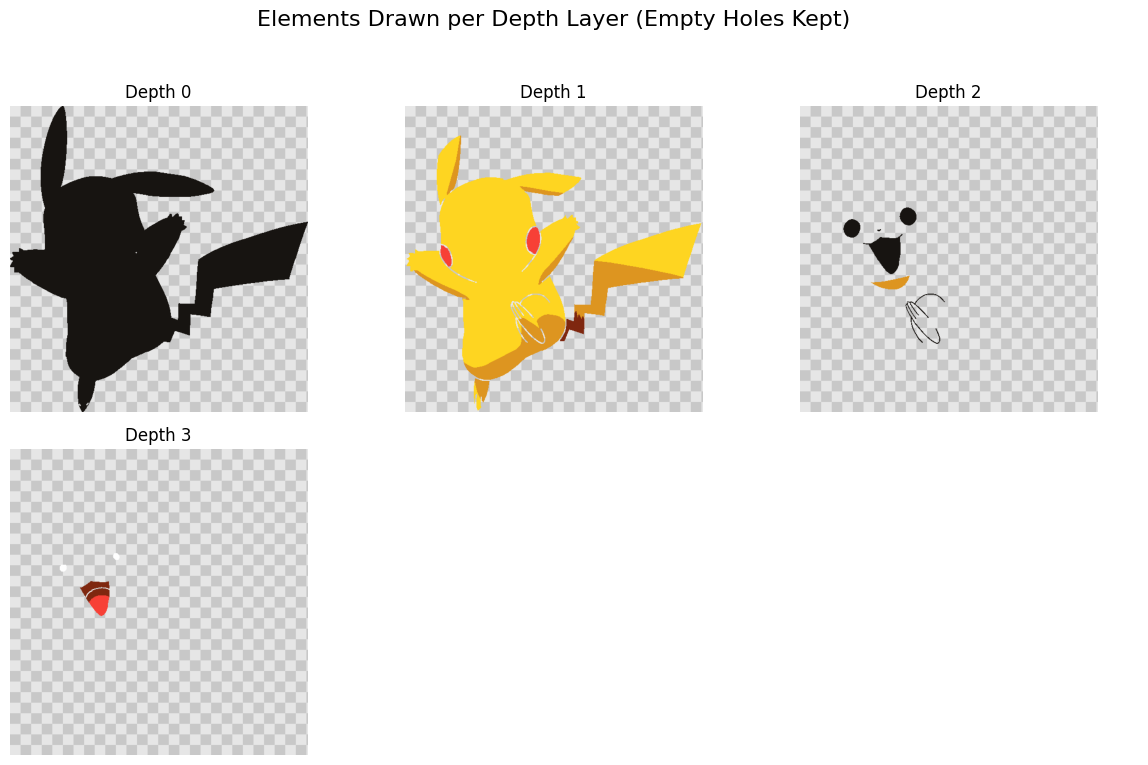


Generating final depth-stacked reconstruction with masking...
 Reconstructing with 27 elements...


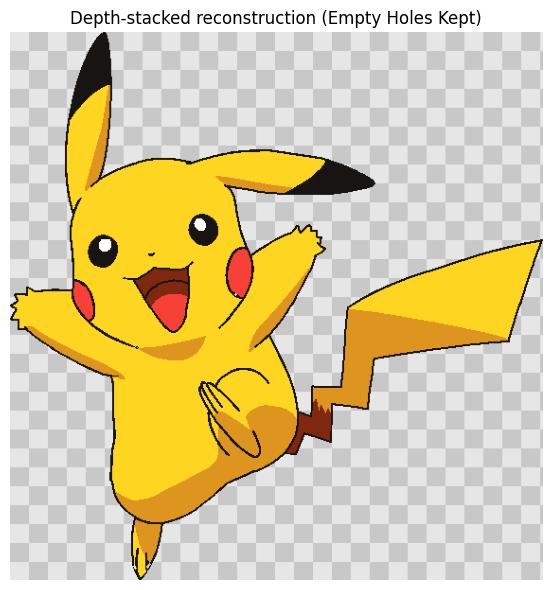


Checkerboard visualization script finished.


In [101]:
# --- Helper Function: Apply Element using Masking ---
def apply_element_with_masking(target_canvas, element, labeled_image, elements_list, h, w, color_override=None):
    """
    Applies an element's color to a target canvas using masking to handle empty holes.

    Args:
        target_canvas: The numpy array (h, w, 3) BGR canvas to draw on.
        element: The element dictionary to draw (must contain 'label_id', 'children', 'contour').
        labeled_image: The original labeled image (for finding holes based on label_id).
        elements_list: The full list of element dictionaries (for child centroid checks).
        h: Image height.
        w: Image width.
        color_override: Optional BGR tuple to use instead of element['colour'].
    """
    # Basic checks for required keys
    if not all(k in element for k in ['label_id', 'children', 'contour', 'depth']):
         print(f"Warning: Element {element.get('id', 'N/A')} is missing required keys for masking. Skipping.")
         return
    if element['depth'] is None or element['depth'] == -1:
        # print(f"Debug: Skipping element {element['id']} due to invalid depth.")
        return # Skip invalid depth elements

    element_color = color_override if color_override is not None else element['colour']
    label_id = element['label_id']

    # 1. Start with an empty mask for this element
    element_mask = np.zeros((h, w), dtype=np.uint8)

    # 2. Find all contours and hierarchy for the original component mask
    # It's crucial that labeled_image corresponds to the state where label_id uniquely identifies the component's shape including its holes
    comp_mask_holes = (labeled_image == label_id).astype(np.uint8) * 255
    if cv2.countNonZero(comp_mask_holes) == 0:
        # print(f"Debug: No pixels found for label_id {label_id} in labeled_image for element {element['id']}. Cannot create mask.")
        return # Cannot proceed if the mask is empty

    contours_including_holes, hierarchy_holes = cv2.findContours(
        comp_mask_holes, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
    )

    outer_contour_index_in_list = -1
    empty_hole_contours = [] # Store contours of holes confirmed to be empty

    if hierarchy_holes is not None and len(hierarchy_holes) > 0:
        hierarchy_holes = hierarchy_holes[0] # Remove outer list wrapper

        # 3. Identify the index of the main outer contour
        possible_outer_indices = [idx for idx, hier_info in enumerate(hierarchy_holes) if hier_info[3] == -1]
        if not possible_outer_indices:
             # Fallback: Use the stored main contour if hierarchy is weird
             # print(f"Warning: Could not find outer contour index (-1 parent) for element {element['id']} (label {label_id}). Using stored contour as fallback.")
             cv2.drawContours(element_mask, [element['contour']], -1, 255, cv2.FILLED)
        else:
             if len(possible_outer_indices) > 1:
                 outer_contour_index_in_list = max(possible_outer_indices, key=lambda idx: cv2.contourArea(contours_including_holes[idx]))
                 # print(f"Warning: Multiple top-level contours found for element {element['id']} (label {label_id}). Selecting largest.")
             else:
                 outer_contour_index_in_list = possible_outer_indices[0]

             # Draw the identified outer contour filled white (255) onto the mask
             cv2.drawContours(element_mask, [contours_including_holes[outer_contour_index_in_list]], -1, 255, cv2.FILLED)

             # 4. Find and identify direct empty holes of the outer contour
             for hole_index, hier_info in enumerate(hierarchy_holes):
                 if hier_info[3] == outer_contour_index_in_list: # Check if parent is the outer contour
                     hole_contour = contours_including_holes[hole_index]
                     if cv2.contourArea(hole_contour) < 1: continue # Skip tiny holes

                     is_empty_hole = True
                     # instead of only children, consider *all* elements deeper than this one
                     current_depth = element['depth']
                     deeper_elements = [
                         el for el in elements_list
                         if el.get('depth') is not None and el['depth'] > current_depth
                     ]
                     for other in deeper_elements:
                         if cv2.pointPolygonTest(hole_contour, tuple(other['centroid']), False) >= 0:
                              is_empty_hole = False
                              break
                     if is_empty_hole:
                         empty_hole_contours.append(hole_contour)

             # 5. Erase the empty holes from the mask
             if empty_hole_contours:
                 cv2.drawContours(element_mask, empty_hole_contours, -1, 0, cv2.FILLED)

    else:
         # Fallback if no hierarchy found (e.g., element likely has no holes)
         # print(f"Debug: No hierarchy found for element {element['id']} (label {label_id}). Using stored contour.")
         cv2.drawContours(element_mask, [element['contour']], -1, 255, cv2.FILLED)


    # 6. Apply Color using the Final Mask
    # Ensure target_canvas has 3 channels
    if target_canvas.ndim == 3 and target_canvas.shape[2] == 3:
         target_canvas[element_mask == 255] = element_color
    else:
         print(f"Error: target_canvas for element {element.get('id','N/A')} does not have 3 channels. Shape: {target_canvas.shape}")


# --- Checkerboard Function ---
def make_checkerboard(H, W, block=20, a=(230,230,230), b=(200,200,200)):
    """Creates a checkerboard pattern image."""
    # Ensure block size is positive
    block = max(1, block)
    # Create indices
    yy, xx = np.indices((H, W))
    # Calculate pattern: 0 or 1
    patt = ((yy // block) + (xx // block)) % 2
    # Create empty BGR canvas
    board = np.empty((H, W, 3), np.uint8)
    # Assign colors based on pattern
    board[patt == 0] = a # Color 'a' where pattern is 0
    board[patt == 1] = b # Color 'b' where pattern is 1
    return board

# --- Generate canvases per depth using MASKING ---
print("\nGenerating canvases per depth with masking...")

# Ensure elements list is not empty and depths are valid
if not elements:
     print("Error: Elements list is empty. Cannot generate canvases.")
     canvases = []
     depths = []
else:
     valid_elements = [e for e in elements if e.get('depth') is not None and e['depth'] != -1]
     if not valid_elements:
          print("Error: No elements with valid depth found.")
          canvases = []
          depths = []
     else:
          depths = sorted({e['depth'] for e in valid_elements})
          canvases = [] # List to store (depth, canvas) tuples

          for d in depths:
               print(f" Generating canvas for depth {d}...")
               # Create a fresh checkerboard for this depth layer
               cb = make_checkerboard(h, w)
               # Iterate through ALL elements to find those at the current depth
               elements_at_depth = [e for e in elements if e.get('depth') == d]
               # Sort elements at this depth by area (optional, larger drawn first)
               elements_at_depth.sort(key=lambda x: x.get('area', 0), reverse=True)

               for e in elements_at_depth:
                    # Use the masking function to draw the element correctly
                    apply_element_with_masking(
                         target_canvas=cb,
                         element=e,
                         labeled_image=labeled_image,
                         elements_list=elements, # Pass the full list for child checks
                         h=h,
                         w=w,
                         color_override=e['colour'] # Use the element's actual color
                    )
               canvases.append((d, cb)) # Add the finished canvas for this depth


# --- Display canvases in grid ---
if canvases:
     print("Displaying depth canvases...")
     cols = 3
     rows = math.ceil(len(canvases) / cols)
     plt.figure(figsize=(cols * 4, rows * 4))
     for i, (d, cb) in enumerate(canvases, 1):
          plt.subplot(rows, cols, i)
          plt.imshow(cv2.cvtColor(cb, cv2.COLOR_BGR2RGB))
          plt.title(f'Depth {d}')
          plt.axis('off')
     # fill empty slots if any
     for j in range(i + 1, rows * cols + 1):
          # Add empty subplot to maintain grid structure
          try:
               plt.subplot(rows, cols, j)
               plt.axis('off')
          except ValueError: # Avoid error if grid size is exactly matched
               pass
     plt.suptitle('Elements Drawn per Depth Layer (Empty Holes Kept)', fontsize=16)
     plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
     plt.show()
else:
     print("No canvases were generated to display.")


# --- Final reconstruction using MASKING ---
print("\nGenerating final depth-stacked reconstruction with masking...")
final = make_checkerboard(h, w)

if elements:
     # Sort all valid elements by depth (ascending), then area (descending) for correct draw order
     draw_order = sorted(
          [e for e in elements if e.get('depth') is not None and e['depth'] != -1],
          key=lambda e: (e['depth'], -e.get('area', 0))
     )

     if not draw_order:
          print("Warning: No elements with valid depth found for final reconstruction.")
     else:
          print(f" Reconstructing with {len(draw_order)} elements...")
          # Iterate through sorted elements and apply them using the masking function
          for e in draw_order:
               apply_element_with_masking(
                    target_canvas=final,
                    element=e,
                    labeled_image=labeled_image,
                    elements_list=elements, # Pass the full list for child checks
                    h=h,
                    w=w,
                    color_override=e['colour'] # Use the element's actual color
               )

          # --- Display Final Reconstruction ---
          plt.figure(figsize=(6, 6))
          plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
          plt.title('Depth-stacked reconstruction (Empty Holes Kept)')
          plt.axis('off')
          plt.tight_layout()
          plt.show()
else:
     print("Elements list is empty. Cannot generate final reconstruction.")

print("\nCheckerboard visualization script finished.")


Displaying final elements grouped by depth...


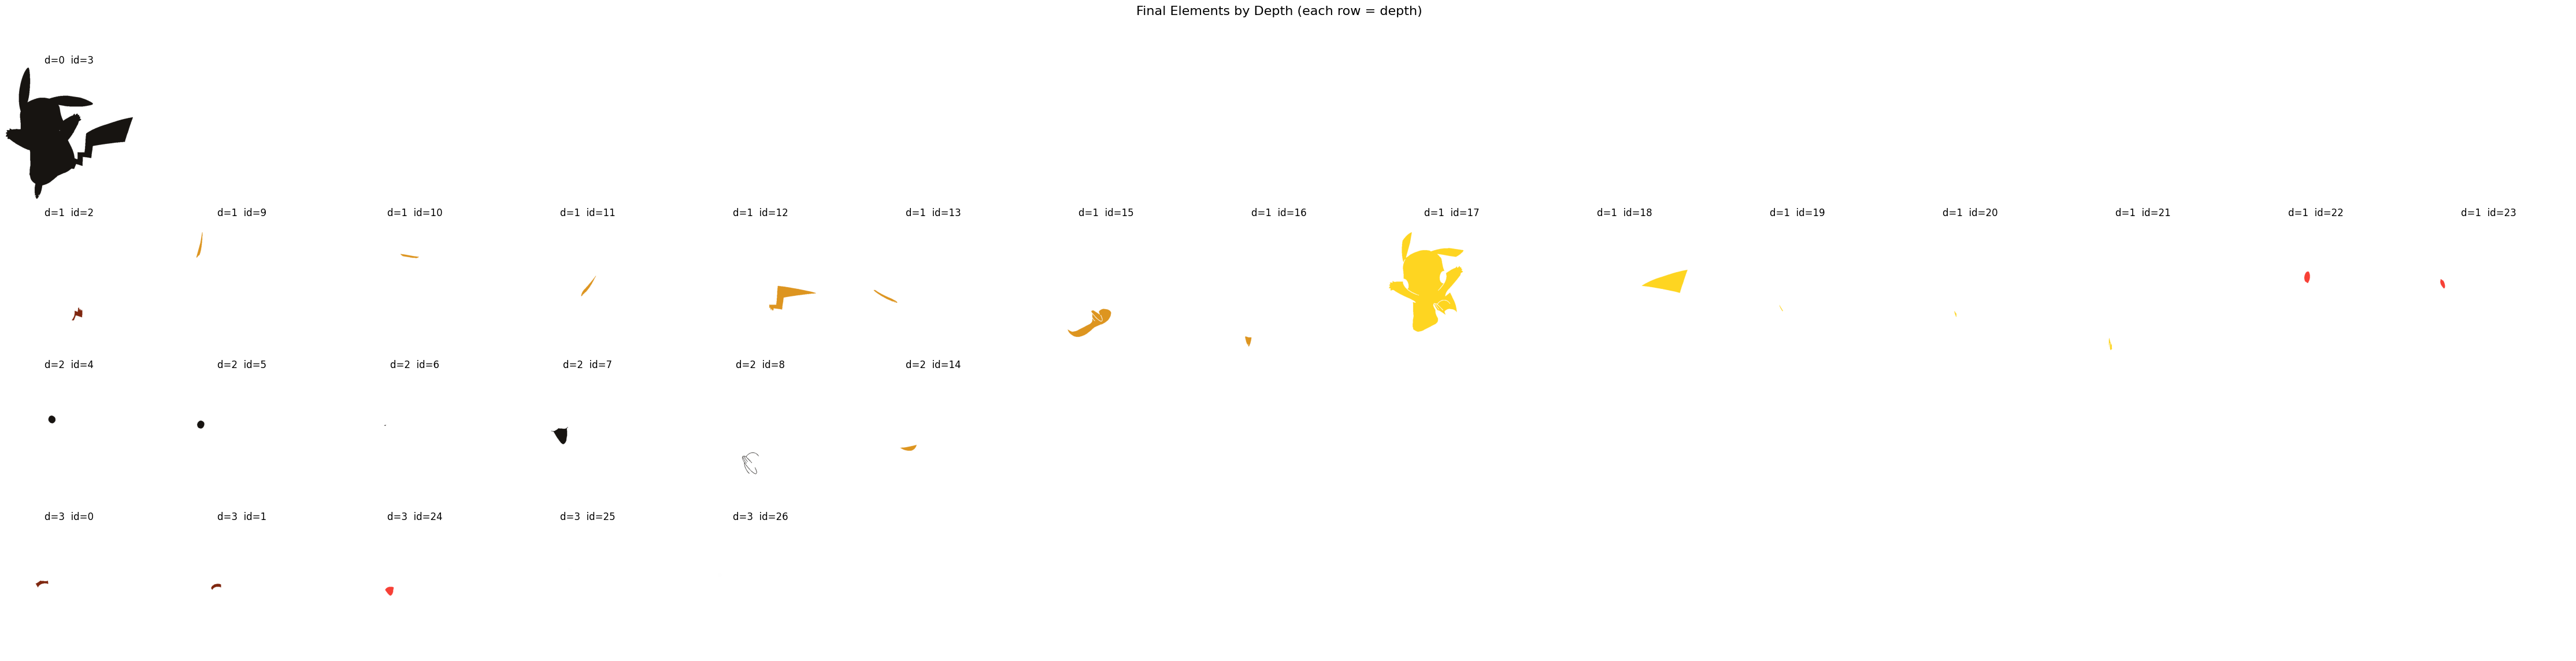

In [104]:
print("Displaying final elements grouped by depth...")

# Filter valid elements and group by depth
final_elements = [e for e in elements if e.get('depth') is not None and e['depth'] != -1]
if not final_elements:
    print("No final elements to display.")
else:
    # Group elements by their depth
    depth_groups = {}
    for e in final_elements:
        depth_groups.setdefault(e['depth'], []).append(e)

    depths_sorted = sorted(depth_groups.keys())
    # Determine grid size: one row per depth, columns = max elements in any depth
    rows = len(depths_sorted)
    cols = max(len(depth_groups[d]) for d in depths_sorted)

    fig, axes = plt.subplots(rows, cols,
                             figsize=(cols * 3, rows * 3),
                             squeeze=False)

    for row_idx, depth in enumerate(depths_sorted):
        group = depth_groups[depth]
        for col_idx in range(cols):
            ax = axes[row_idx][col_idx]
            if col_idx < len(group):
                e = group[col_idx]
                # create blank background
                canvas = np.full((h, w, 3), background_color_bgr, dtype=np.uint8)
                # draw only this element with masking (handles holes)
                apply_element_with_masking(
                    target_canvas=canvas,
                    element=e,
                    labeled_image=labeled_image,
                    elements_list=elements,
                    h=h,
                    w=w,
                    color_override=e['colour']
                )
                ax.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
                ax.set_title(f"d={depth}  id={e['id']}")
            ax.axis('off')

    plt.suptitle("Final Elements by Depth (each row = depth)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## SVG Conversion

In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# Helpers
# ──────────────────────────────────────────────────────────────────────────────
def contour_to_svg_path(cnt):
    pts = cnt.reshape(-1, 2)
    if len(pts) == 0:
        return ""
    return (
        f"M {pts[0][0]} {pts[0][1]} "
        + " ".join(f"L {x} {y}" for x, y in pts[1:])
        + " Z"
    )

def bgr_to_hex(bgr):
    r, g, b = bgr[2], bgr[1], bgr[0]
    return f"#{r:02x}{g:02x}{b:02x}"

# ──────────────────────────────────────────────────────────────────────────────
# Prepare output
# ──────────────────────────────────────────────────────────────────────────────
output_folder = "exported_svgs"
os.makedirs(output_folder, exist_ok=True)
output_file = os.path.join(output_folder, "all_elements_depth_sorted.svg")


# ──────────────────────────────────────────────────────────────────────────────
# Build combined SVG content, sorting by depth ascending
# ──────────────────────────────────────────────────────────────────────────────
svg_header = f'''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg xmlns="http://www.w3.org/2000/svg"
     width="{w}" height="{h}"
     viewBox="0 0 {w} {h}">
'''

# sort elements so depth=0 drawn first, then depth=1, etc.
sorted_elems = sorted(elements, key=lambda e: e["depth"])

svg_groups = []
for elem in sorted_elems:
    cnt   = elem["contour"]
    col   = elem["colour"]
    eid   = elem["id"]
    depth = elem.get("depth", 0)
    area  = elem.get("area", 0.0)

    d = contour_to_svg_path(cnt)
    if not d:
        continue

    x, y, w, h = cv2.boundingRect(cnt)
    title = f"Element {eid} (depth {depth}, color {col})"
    desc  = f"bbox: x={x},y={y},w={w},h={h}; area={area:.1f}"
    fill_hex = bgr_to_hex(col)

    # include a data‑depth attribute for clarity
    group = f'''  <g id="elem_{eid}" data-depth="{depth}">
    <title>{title}</title>
    <desc>{desc}</desc>
    <path d="{d}" fill="{fill_hex}" stroke="none"/>
  </g>'''
    svg_groups.append(group)

svg_footer = "\n</svg>\n"

# ──────────────────────────────────────────────────────────────────────────────
# Write single SVG
# ──────────────────────────────────────────────────────────────────────────────
with open(output_file, "w", encoding="utf-8") as f:
    f.write(svg_header)
    f.write("\n".join(svg_groups))
    f.write(svg_footer)

print(f"Exported combined SVG with {len(svg_groups)} elements (depth‑sorted) to '{output_file}'")


Exported combined SVG with 99 elements (depth‑sorted) to 'exported_svgs\all_elements_depth_sorted.svg'
